In [57]:
from sklearn.cluster import KMeans
from sklearn.metrics import (
  silhouette_score,
  roc_auc_score,
  precision_score,
  recall_score,
  f1_score,
)
from matplotlib import pyplot as plt
import pandas as pd
import numpy as np

### Read in PCA train dataset


In [58]:
df = pd.read_csv('../data/pca_kdd_train.csv')
df.head()

,pc01,pc02,pc03,pc04,pc05,pc06,pc07,pc08,pc09,pc10,pc11,pc12,pc13,pc14,pc15,pc16,pc17,pc18,attack_flag
0,1.247647,-0.041808,0.010407,0.799421,-0.558282,0.338620,-0.041974,0.015865,-0.095879,-0.267315,0.170902,-0.026870,0.080810,0.938859,-1.807150,0.376937,-0.104302,0.336654,0
1,-0.029543,0.876759,0.193490,2.813182,-1.076276,1.770370,-1.240153,0.750788,0.302822,-0.300577,-0.502612,-0.035550,0.067276,-0.218110,-1.036934,0.375675,0.707176,1.333124,0
2,-3.671773,-1.888484,0.082022,-0.231841,-0.245227,-0.610488,-0.055849,0.038519,0.059830,0.259092,0.172752,-0.108912,-0.157117,-0.268797,0.169328,-0.019794,0.273724,-0.115400,1
3,2.541464,-0.732755,-0.202039,-1.202173,-0.659698,-0.620296,-0.208194,0.164284,0.141734,0.327304,0.087751,-0.182505,-0.224473,-0.593128,0.004000,-0.023015,-0.149531,-0.097066,0
4,2.393868,-0.726703,-0.409079,-1.435211,0.378896,0.339898,-0.059409,0.051424,0.105630,0.067165,-0.288466,-0.070354,-0.107659,-0.350197,0.531568,-0.126024,0.053036,0.106768,0


### Remove target attribute


In [59]:
X = df.drop(columns=['attack_flag'])

## Determine best k (cluster count) using Silhouette Score


In [60]:
# Calculate the Silhouette Scores (using sampling for speed)
silhouette_scores = []
k_range = range(12, 26)
for k in k_range:
  kmeans = KMeans(n_clusters=k, random_state=42)
  labels = kmeans.fit_predict(X)
  score = silhouette_score(X, labels, sample_size=30000, random_state=42)
  silhouette_scores.append(score)  # store the score
  print(f'k={k}, silhouette score={score:.4f}')

k=12, silhouette score=0.5329
k=13, silhouette score=0.5345
k=14, silhouette score=0.5448
k=15, silhouette score=0.5458
k=16, silhouette score=0.5503
k=17, silhouette score=0.5672
k=18, silhouette score=0.5737
k=19, silhouette score=0.5772
k=20, silhouette score=0.5796
k=21, silhouette score=0.5014
k=22, silhouette score=0.5078
k=23, silhouette score=0.5113
k=24, silhouette score=0.5116
k=25, silhouette score=0.5167


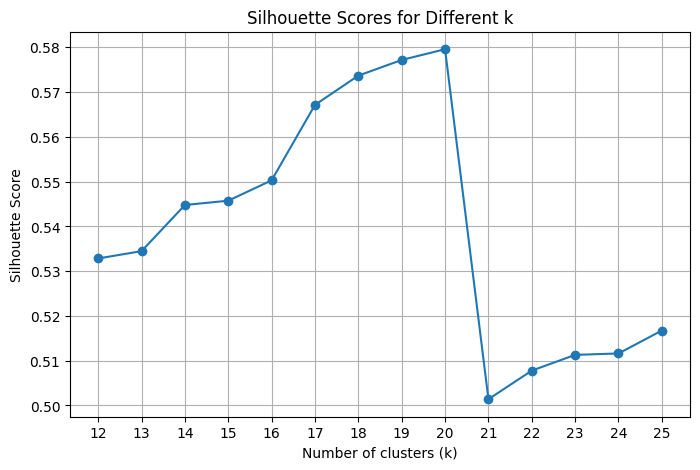

In [61]:
# Plot the Silhouette Scores
plt.figure(figsize=(8, 5))
plt.plot(k_range, silhouette_scores, marker='o')
plt.xlabel('Number of clusters (k)')
plt.ylabel('Silhouette Score')
plt.title('Silhouette Scores for Different k')
plt.xticks(k_range)
plt.grid(True)
plt.show()

## Determine best k (cluster count) using the Elbow Method


In [62]:
distorsions = []
results = []
for k in range(2, 20):
  kmeans = KMeans(n_clusters=k, random_state=24)
  kmeans.fit(X)
  distorsions.append(kmeans.inertia_)

In [63]:
# Method 1: Elbow method using the "kneedle" algorithm (distance from line)
# Find the point with maximum distance from the line connecting first and last points
def find_elbow(values):
  # Normalize the values
  n_points = len(values)
  all_coords = np.vstack((range(n_points), values)).T
  first_point = all_coords[0]
  last_point = all_coords[-1]

  # Vector from first to last point
  line_vec = last_point - first_point
  line_vec_norm = line_vec / np.sqrt(np.sum(line_vec**2))

  # Vector from first point to each point
  vec_from_first = all_coords - first_point

  # Distance from each point to the line
  scalar_product = np.sum(vec_from_first * line_vec_norm, axis=1)
  vec_to_line = vec_from_first - np.outer(scalar_product, line_vec_norm)
  dist_to_line = np.sqrt(np.sum(vec_to_line**2, axis=1))

  # Find the index with maximum distance
  elbow_idx = np.argmax(dist_to_line)
  return elbow_idx


elbow_idx = find_elbow(distorsions)
optimal_k = elbow_idx + 2  # +2 because we started at k=2

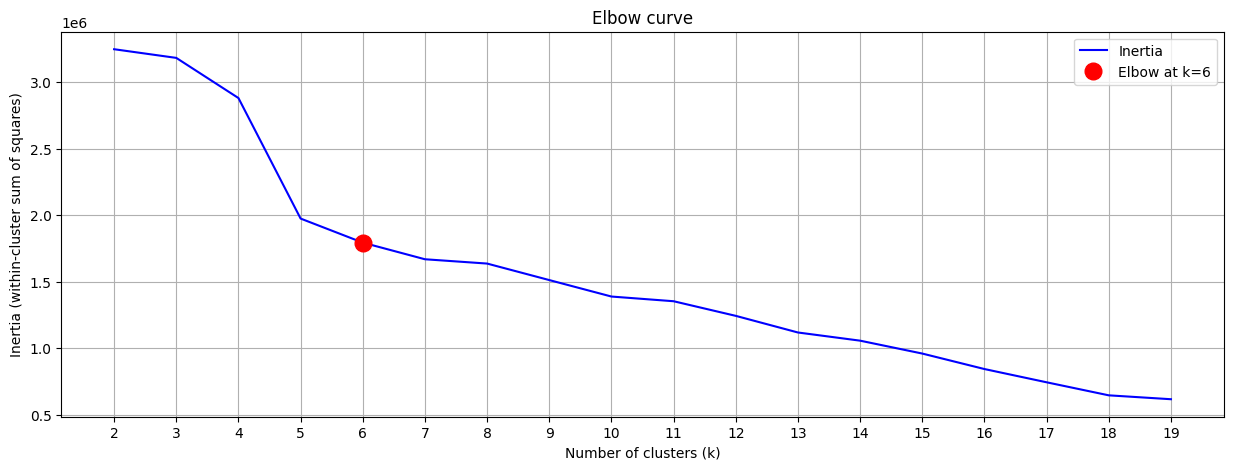

In [64]:
# Plotting
fig = plt.figure(figsize=(15, 5))
plt.plot(range(2, 20), distorsions, 'b-', label='Inertia')
plt.plot(
  optimal_k,
  distorsions[elbow_idx],
  'ro',
  markersize=12,
  label=f'Elbow at k={optimal_k}',
)
plt.grid(True)
plt.title('Elbow curve')
plt.xlabel('Number of clusters (k)')
plt.ylabel('Inertia (within-cluster sum of squares)')
plt.xticks(range(2, 20))
plt.legend()
plt.show()

### Train KMEANS model with optimal k values


An average of the Silhouette Score and Elbow Algorithm were used to determine the optimal number of clusters. Below are the results further detailed by normal and attack type.


In [65]:
# Train KMeans
k = 20
kmeans_final = KMeans(n_clusters=k, random_state=24)
cluster_labels = kmeans_final.fit_predict(X)

# Add cluster labels to dataframe
df['cluster'] = cluster_labels

# Print cluster count and description
print('=' * 80)
print(f'CLUSTER ANALYSIS FOR K={k} (simplified labels: attack vs normal)')
print('=' * 80)

# Iterate over clusters and explain results
for i in range(k):
  cluster_data = df[df['cluster'] == i]
  cluster_size = len(cluster_data)
  cluster_pct = (cluster_size / len(df)) * 100

  print(f'\n--- Cluster {i} ---')
  print(f'Size: {cluster_size:,} samples ({cluster_pct:.2f}%)')

  # Use simplified labels
  simplified_dist = cluster_data['attack_flag'].value_counts()
  for label, count in simplified_dist.items():
    pct = (count / cluster_size) * 100
    print(f'  {label}: {count:,} ({pct:.2f}%)')

CLUSTER ANALYSIS FOR K=20 (simplified labels: attack vs normal)

--- Cluster 0 ---
Size: 2,692 samples (2.14%)
  1: 2,678 (99.48%)
  0: 14 (0.52%)

--- Cluster 1 ---
Size: 34,824 samples (27.64%)
  0: 33,939 (97.46%)
  1: 885 (2.54%)

--- Cluster 2 ---
Size: 34,785 samples (27.61%)
  1: 34,714 (99.80%)
  0: 71 (0.20%)

--- Cluster 3 ---
Size: 10,938 samples (8.68%)
  1: 8,130 (74.33%)
  0: 2,808 (25.67%)

--- Cluster 4 ---
Size: 5,434 samples (4.31%)
  0: 5,303 (97.59%)
  1: 131 (2.41%)

--- Cluster 5 ---
Size: 26 samples (0.02%)
  0: 25 (96.15%)
  1: 1 (3.85%)

--- Cluster 6 ---
Size: 115 samples (0.09%)
  0: 61 (53.04%)
  1: 54 (46.96%)

--- Cluster 7 ---
Size: 4,124 samples (3.27%)
  1: 3,862 (93.65%)
  0: 262 (6.35%)

--- Cluster 8 ---
Size: 804 samples (0.64%)
  0: 517 (64.30%)
  1: 287 (35.70%)

--- Cluster 9 ---
Size: 884 samples (0.70%)
  1: 884 (100.00%)

--- Cluster 10 ---
Size: 19 samples (0.02%)
  0: 19 (100.00%)

--- Cluster 11 ---
Size: 17,372 samples (13.79%)
  0: 14,716

### Generate a graph of clusters by type


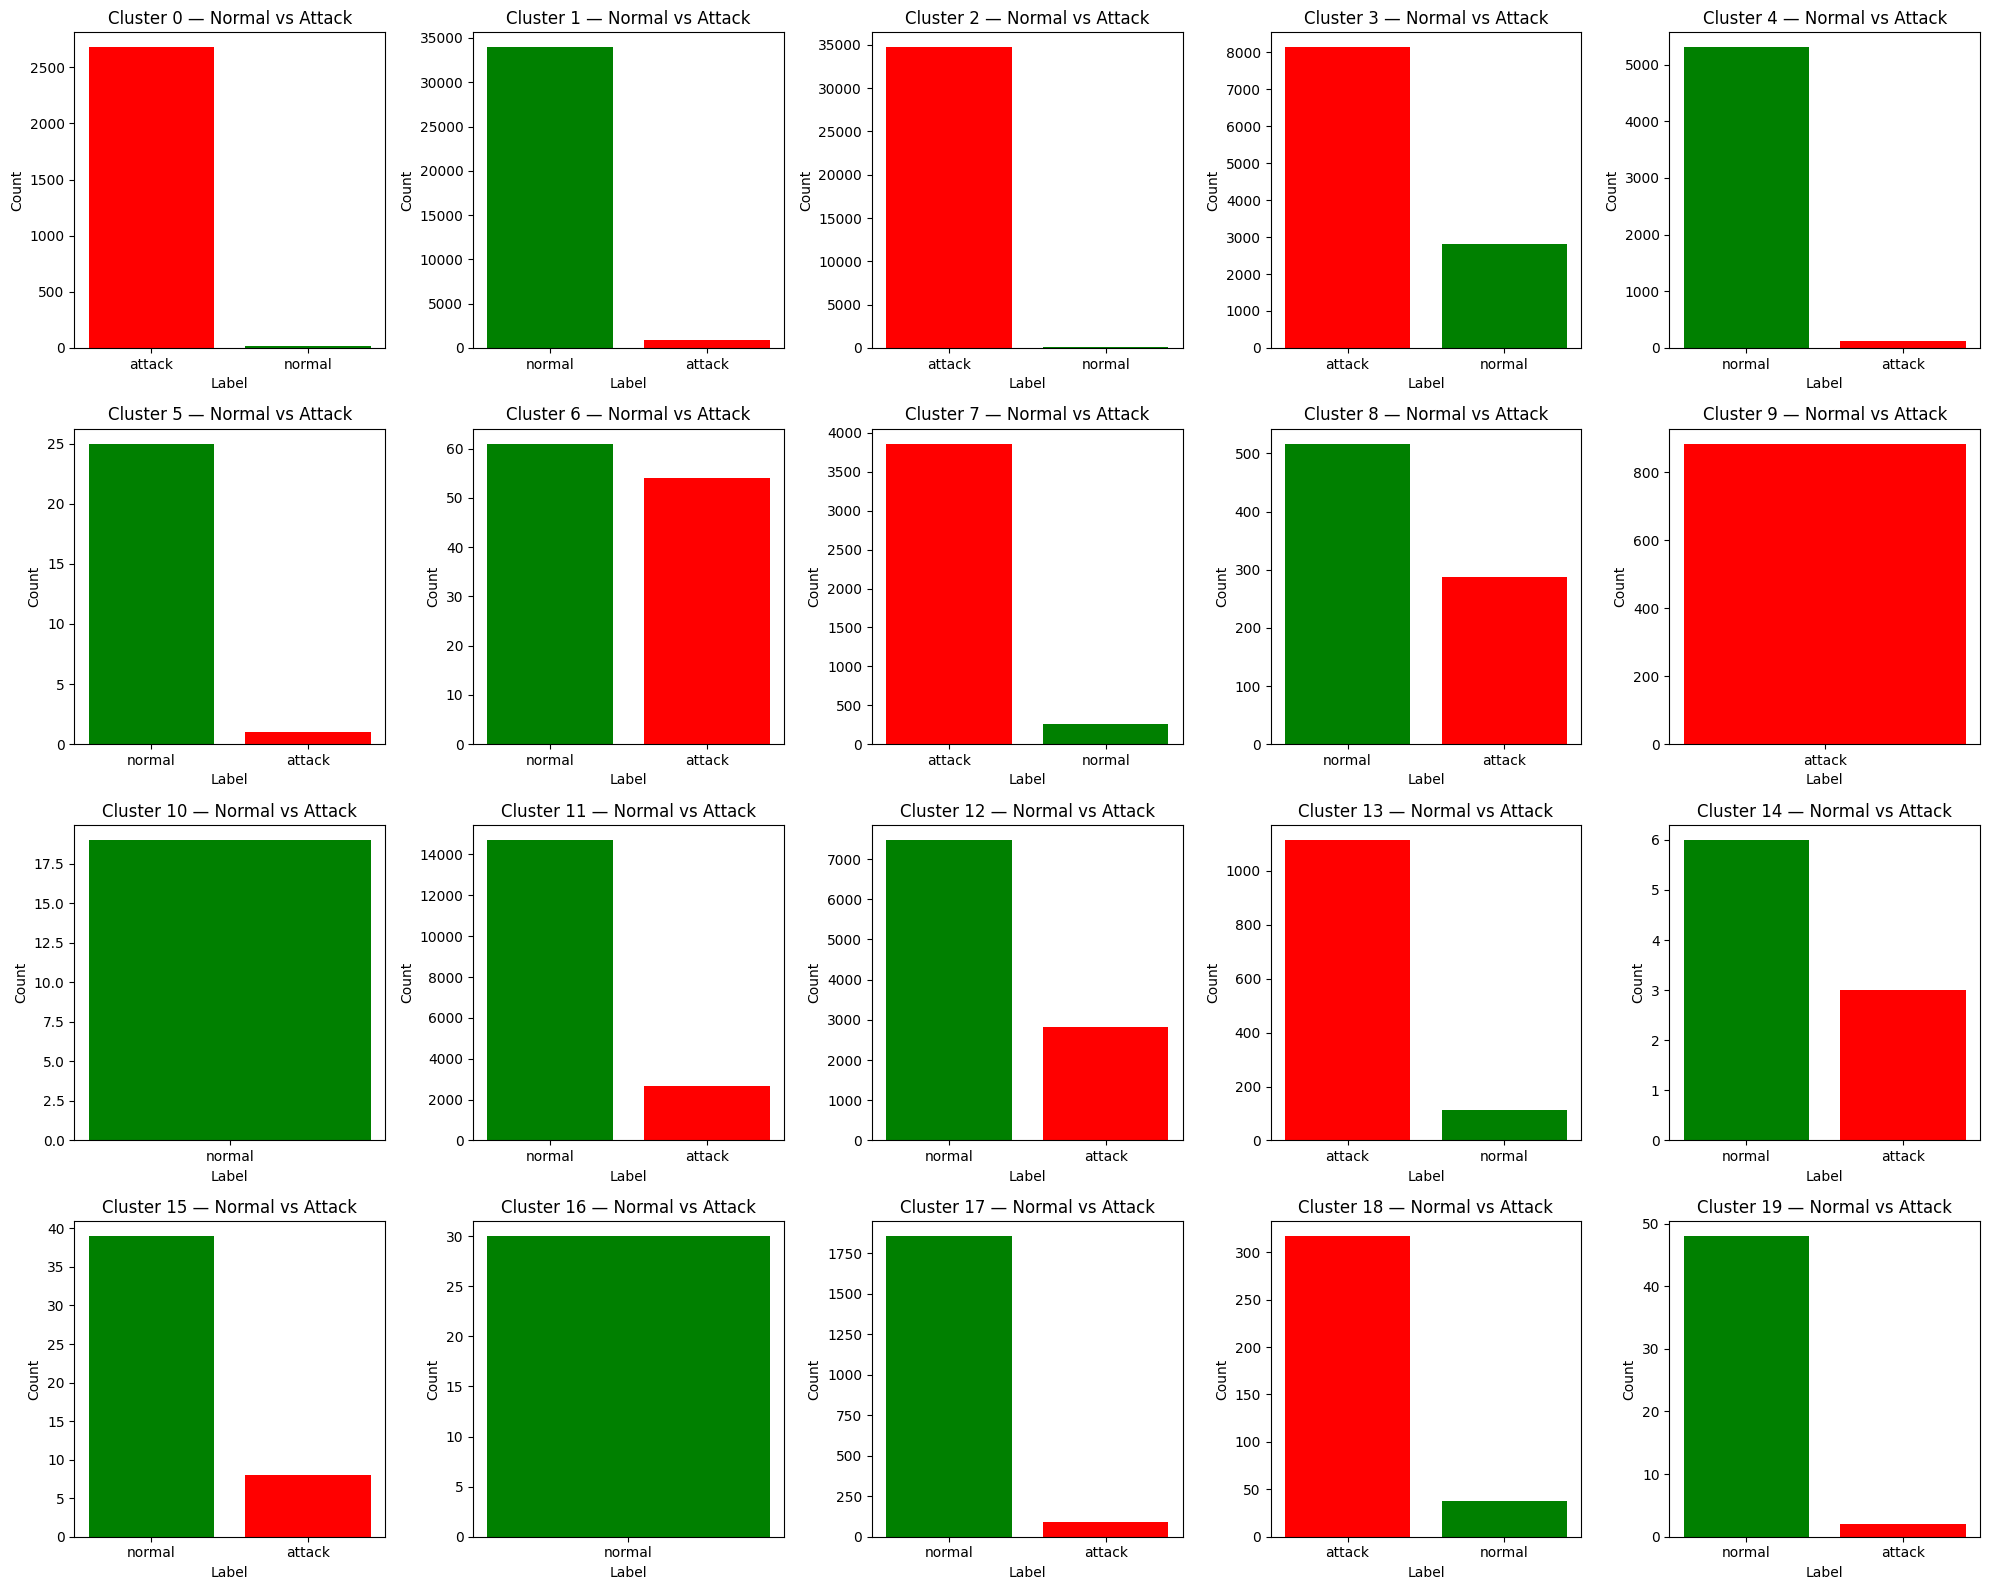

In [ ]:
k = df['cluster'].nunique()

# Calculate rows needed for 5 columns
n_cols = 5
n_rows = (k + n_cols - 1) // n_cols  # Ceiling division

# Create subplot grid
fig, axes = plt.subplots(n_rows, n_cols, figsize=(20, 4 * n_rows))
axes = axes.flatten()  # Flatten to 1D array for easy indexing

for i in range(k):
  cluster_data = df[df['cluster'] == i]

  # Count normal (0) vs attack (1)
  counts = cluster_data['attack_flag'].value_counts()

  # Map to labels
  labels = ['normal' if idx == 0 else 'attack' for idx in counts.index]
  colors = ['green' if idx == 0 else 'red' for idx in counts.index]

  # Plot on subplot
  axes[i].bar(labels, counts.values, color=colors)
  axes[i].set_title(f'Cluster {i} — Normal vs Attack')
  axes[i].set_xlabel('Label')
  axes[i].set_ylabel('Count')

# Hide unused subplots
for j in range(k, len(axes)):
  axes[j].axis('off')

plt.tight_layout()
plt.show()

From the results, we can see that KMEANS can generate clusters well for some instances of normal and attack types; however, it is unable to correctly generate clusters in every case. This makes it an unreliable solution and not the best option for classifying future network traffic. It is likely that this model is too simple for the data.


## Evaluate the model using the test set

In [73]:
test_df = pd.read_csv('../data/pca_kdd_test.csv')
X_test = test_df.drop(columns=['attack_flag'])
y_test = test_df['attack_flag']

In [74]:
# Learn cluster majority labels from TRAINING data
# Calculate attack rate per cluster from training set
cluster_attack_rates = df.groupby('cluster')['attack_flag'].mean()

# Assign cluster labels based on majority (>= 0.5 means attack cluster)
cluster_labels = (cluster_attack_rates >= 0.5).astype(int)

print('\n' + '=' * 80)
print("Cluster Majority Labels (learned from training data)")
print('=' * 80)
for cluster_id in range(len(cluster_labels)):
    label = cluster_labels[cluster_id]
    rate = cluster_attack_rates[cluster_id]
    label_str = 'attack' if label == 1 else 'normal'
    print(f'  Cluster {cluster_id}: {label_str} (attack rate: {rate:.2%})')

# Apply to TEST data
test_clusters = kmeans_final.predict(X_test)
test_df['cluster'] = test_clusters
test_df['pred_label'] = test_df['cluster'].map(cluster_labels)
test_df['pred_proba'] = test_df['cluster'].map(cluster_attack_rates)

# Get test predictions
y_true = y_test.values
y_pred = test_df['pred_label'].values
y_proba = test_df['pred_proba'].values

# Calculate ROC-AUC on test set
auc = roc_auc_score(y_true, y_proba)

print('\n' + '=' * 80)
print("TEST SET Evaluation - KMeans Classification")
print('=' * 80)
print(f'ROC-AUC: {auc:.4f}')


Cluster Majority Labels (learned from training data)
  Cluster 0: attack (attack rate: 99.48%)
  Cluster 1: normal (attack rate: 2.54%)
  Cluster 2: attack (attack rate: 99.80%)
  Cluster 3: attack (attack rate: 74.33%)
  Cluster 4: normal (attack rate: 2.41%)
  Cluster 5: normal (attack rate: 3.85%)
  Cluster 6: normal (attack rate: 46.96%)
  Cluster 7: attack (attack rate: 93.65%)
  Cluster 8: normal (attack rate: 35.70%)
  Cluster 9: attack (attack rate: 100.00%)
  Cluster 10: normal (attack rate: 0.00%)
  Cluster 11: normal (attack rate: 15.29%)
  Cluster 12: normal (attack rate: 27.34%)
  Cluster 13: attack (attack rate: 90.79%)
  Cluster 14: normal (attack rate: 33.33%)
  Cluster 15: normal (attack rate: 17.02%)
  Cluster 16: normal (attack rate: 0.00%)
  Cluster 17: normal (attack rate: 4.62%)
  Cluster 18: attack (attack rate: 89.30%)
  Cluster 19: normal (attack rate: 4.00%)

TEST SET Evaluation - KMeans Classification
ROC-AUC: 0.9052


In [ ]:
# Calculate classification metrics on TEST SET
from sklearn.metrics import roc_curve

# Calculate metrics
precision = precision_score(y_true, y_pred)
recall = recall_score(y_true, y_pred)
f1 = f1_score(y_true, y_pred)

# Generate ROC curve data for plotting
fpr, tpr, thresholds = roc_curve(y_true, y_proba)

print('\n--- Classification Metrics ---')
print(f'Precision: {precision:.4f}')
print(f'Recall:    {recall:.4f}')
print(f'F1 Score:  {f1:.4f}')
print(f'ROC-AUC:   {auc:.4f}')


--- Classification Metrics (Test Set) ---
Precision: 0.9790
Recall:    0.6105
F1 Score:  0.7521
ROC-AUC:   0.9052


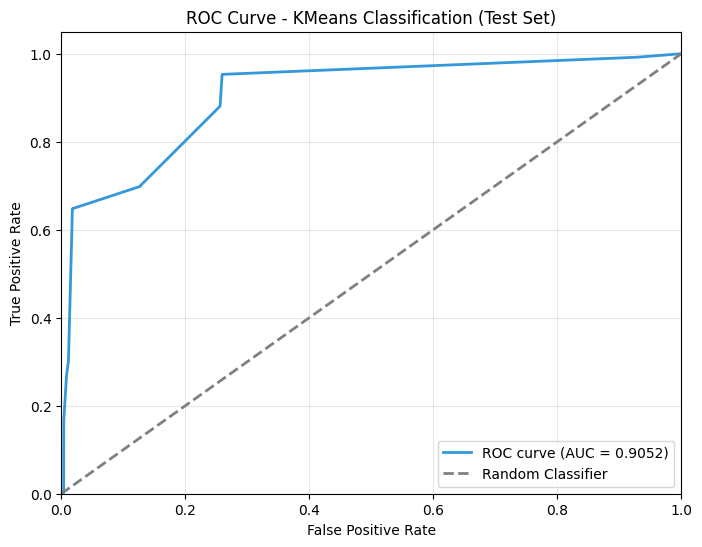

In [76]:
# Plot ROC Curve (Test Set)
plt.figure(figsize=(8, 6))
plt.plot(fpr, tpr, color='#3498db', lw=2, label=f'ROC curve (AUC = {auc:.4f})')
plt.plot([0, 1], [0, 1], color='grey', lw=2, linestyle='--', label='Random Classifier')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('ROC Curve - KMeans Classification (Test Set)')
plt.legend(loc="lower right")
plt.grid(True, alpha=0.3)
plt.show()